In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../src/")
import json

import numpy as np
import pandas as pd
import math
from datasets import Dataset, list_metrics, load_metric
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, Trainer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from runners.runner_utils import loss_to_perplexity

In [3]:
base_result_dir = "/data/ddmg/personalizedmentalhealth/reddit_project/results"

## 1 - Pretrained BERT

## 2 - BERT + finetune all Reddit

In [5]:
exp_dir = os.path.join(base_result_dir, "2_bert_finetuned")

In [6]:
trainer_state = json.load(open(os.path.join(exp_dir, "trainer_state.json"), "rb"))

In [7]:
trainer_state

{'best_metric': 1.596421718597412,
 'best_model_checkpoint': '/data/ddmg/personalizedmentalhealth/reddit_project/results/2_bert_finetuned/checkpoint-19500',
 'epoch': 0.4573599774838165,
 'global_step': 19500,
 'is_hyper_param_search': False,
 'is_local_process_zero': True,
 'is_world_process_zero': True,
 'log_history': [{'epoch': 0.01,
   'learning_rate': 4.980454701816931e-05,
   'loss': 1.9304,
   'step': 500},
  {'epoch': 0.01,
   'eval_loss': 2.045539617538452,
   'eval_runtime': 109.4155,
   'eval_samples_per_second': 66.042,
   'step': 500},
  {'epoch': 0.02,
   'learning_rate': 4.9609094036338624e-05,
   'loss': 1.7981,
   'step': 1000},
  {'epoch': 0.02,
   'eval_loss': 1.971427321434021,
   'eval_runtime': 109.2669,
   'eval_samples_per_second': 66.132,
   'step': 1000},
  {'epoch': 0.04,
   'learning_rate': 4.941364105450793e-05,
   'loss': 1.7553,
   'step': 1500},
  {'epoch': 0.04,
   'eval_loss': 1.9081579446792603,
   'eval_runtime': 111.3074,
   'eval_samples_per_secon

In [12]:
steps = []
train_loss = []
train_p = []
eval_loss = []
eval_p = []
for item in trainer_state['log_history']:
    if 'loss' in item.keys():
        steps.append(item['step'])
        train_loss.append(item['loss'])
        train_p.append(loss_to_perplexity(item['loss']))
    elif 'eval_loss' in item.keys():
        eval_loss.append(item['eval_loss'])
        eval_p.append(loss_to_perplexity(item['eval_loss']))

<AxesSubplot:>

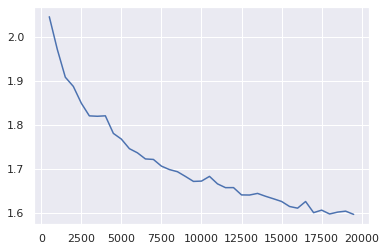

In [14]:
sns.lineplot(x=steps, y=eval_loss)

In [16]:
losses = train_loss + eval_loss
steps_all = steps + steps
data = ["train"] * len(train_loss) + ["val"] * len(eval_loss)
df = pd.DataFrame({"loss": losses, "step": steps_all, "data": data})

In [50]:
eval_loss

[2.045539617538452,
 1.971427321434021,
 1.9081579446792603,
 1.8872828483581543,
 1.8490405082702637,
 1.8203266859054565,
 1.8194189071655273,
 1.8204357624053955,
 1.7804899215698242,
 1.767524242401123,
 1.7458083629608154,
 1.7364189624786377,
 1.722481608390808,
 1.7213186025619507,
 1.7061247825622559,
 1.6982991695404053,
 1.693450689315796,
 1.6827011108398438,
 1.6714177131652832,
 1.6721059083938599,
 1.682835340499878,
 1.6658623218536377,
 1.6572188138961792,
 1.6573295593261719,
 1.6407279968261719,
 1.6404703855514526,
 1.6441466808319092,
 1.637635588645935,
 1.631880521774292,
 1.6258785724639893,
 1.6144154071807861,
 1.6106287240982056,
 1.6257494688034058,
 1.6004316806793213,
 1.6061644554138184,
 1.5974061489105225,
 1.6017032861709595,
 1.6038464307785034,
 1.596421718597412]

<AxesSubplot:xlabel='step', ylabel='loss'>

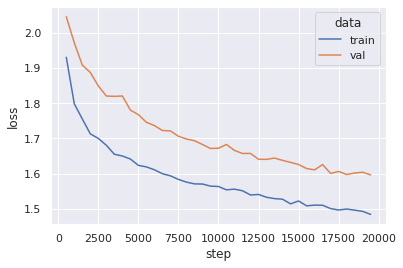

In [18]:
sns.lineplot(data=df, x="step", y="loss", hue="data")

In [19]:
perplexities = train_p + eval_p
df = pd.DataFrame({"loss": losses, "step": steps_all, "data": data, "perplexity": perplexities})

<AxesSubplot:xlabel='step', ylabel='perplexity'>

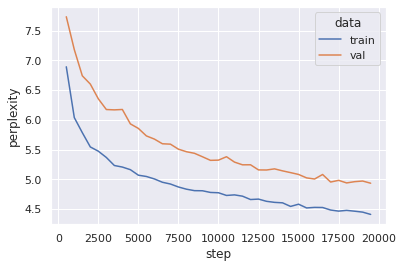

In [20]:
sns.lineplot(data=df, x="step", y="perplexity", hue="data")

In [28]:
train_results = json.load(open(os.path.join(exp_dir, "train_results.json"), "rb"))
eval_results = json.load(open(os.path.join(exp_dir, "eval_results.json"), "rb"))
test_results = json.load(open(os.path.join(exp_dir, "test_results.json"), "rb"))

In [30]:
losses = [train_results['training_loss'], eval_results['eval_loss'], test_results['test_loss']]
perps = [train_results['train_perplexity'], eval_results['eval_perplexity'], test_results['test_perplexity']]
data_splits = ["train", "val", "test"]
df = pd.DataFrame({"data_split": data_splits, "loss": losses, "perplexity": perps})

In [31]:
df

,data_split,loss,perplexity
0,train,1.586269,4.885485
1,val,1.585292,4.880719
2,test,1.619855,5.052359


In [33]:
# get test loss by subreddit and author
author_results = json.load(open(os.path.join(exp_dir, "author_test_results.json"), "rb"))

In [58]:
subreddit_results = json.load(open(os.path.join(exp_dir, "subreddit_test_results.json"), "rb"))

In [68]:
loss_list = []
perp_list = []
srs = []

for key, val in subreddit_results.items():
    if key in ["mean_loss", "std_loss", "mean_perplexity", "std_perplexity"]:
        continue
    subreddit = "_".join(key.split('_')[:-1])
    if 'loss' in key:
        loss_list.append((subreddit, val))
        srs.append(subreddit)
    elif 'perplexity' in key:
        perp_list.append((subreddit, val))

In [69]:
loss_list = sorted(loss_list)
loss_list = [x[1] for x in loss_list]
perp_list = sorted(perp_list)
perp_list = [x[1]for x in perp_list]

In [70]:
sr_results = pd.DataFrame({"subreddit": srs, "loss": loss_list, "perplexity": perp_list})

In [71]:
sr_results

,subreddit,loss,perplexity
0,AskDocs,1.520442,4.574244
1,Bitcoin,1.847334,6.342889
2,family,1.488848,4.431989
3,investing,1.341149,3.823435
4,medical,2.003002,7.411274
5,mentalhealth,1.569690,4.805158
6,personalfinance,1.631887,5.113514
7,relationship_advice,1.395025,4.035074
8,relationships,1.329563,3.779390


In [83]:
loss_list = []
perp_list = []
authors = []

for key, val in author_results.items():
    if key in ["mean_loss", "std_loss", "mean_perplexity", "std_perplexity"]:
        continue
    author = "_".join(key.split('_')[:-1])
    key_type = key.split('_')[-1]
    if key_type == 'loss':
        loss_list.append((author, val))
        authors.append(author)
    elif key_type == 'perplexity':
        perp_list.append((author, val))

In [84]:
loss_list = sorted(loss_list)
loss_list = [x[1] for x in loss_list]
perp_list = sorted(perp_list)
perp_list = [x[1]for x in perp_list]

In [85]:
author_results = pd.DataFrame({"author": authors, "loss": loss_list, "perplexity": perp_list})

In [86]:
author_results

,author,loss,perplexity
0,101111,1.994584,7.349148
1,123wanderlust,2.767086,15.912195
2,19931,1.532237,4.628518
3,1blockologist,1.962229,7.115171
4,1gudboi,1.739380,5.693814
...,...,...,...
591,your_godammn_right,1.579458,4.852326
592,zcc0nonA,1.941078,6.966254
593,zomgitsduke,1.955971,7.070779
594,ztsmart,2.010419,7.466443
